# Tutorial4: Reannotation on scST data (with pre-annoated info)

STAMapper enables unknown cells (on scST data) detection. Here we utilized MERFISH mouse hypothalamic data (ID=15) to show this result, The scRNA-seq dataset and the scST dataset can be download from [Google Drive](https://drive.google.com/drive/folders/1xP3Fh94AwKu4OsH3khGq-KEw0VCoiRnL) (MERFISH_hypothalamic.zip).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
from STAMapper import pipeline, pp, pl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import shutil
import STAMapper
import warnings
warnings.filterwarnings("ignore")

In [2]:
key_class1 = 'celltype'#celltype label for adata_sc, stored in adata_sc.obs[key_class1]
key_class2 = 'celltype'#celltype label for adata_sp, stoted in adata_sp.obs[key_class2]
key_classes = [key_class1, key_class2]

## Load data

We here removed the astrocytes in adata_sc, thus the astrocytes in adata_sp became unknown cells.

In [3]:
adata_sc = sc.read_h5ad(r'../data/hypothalamic_sc.h5ad')
adata_sc = adata_sc[~adata_sc.obs['celltype'].isin(['Astrocytes'])]#remove astrocytes
adata_sp = sc.read_h5ad(r'../data/MERFISH_hypothalamic_15.h5ad') 
adata_sp.obs['celltype'].replace('Astrocytes','unknown',inplace=True)

sc_name = 'hypothalamic_sc_rf_astrocyte'
sp_name = 'hypothalamic_MERFISH'

#change dsnames for a new training task
dsnames = (sc_name, sp_name)

#delete dirs for old task with the same dsnames
if os.path.exists(Path(".") /'_temp' / f'{dsnames}'):
    shutil.rmtree(Path(".") /'_temp' / f'{dsnames}')

## Training

In [4]:
adatas = [adata_sc, adata_sp]

outputs = pipeline.training(adatas=adatas, dsnames=dsnames, key_classes=key_classes)

Data Preprocessing!
[leiden] Time used:  154.1176 s
a new directory made:
	_temp\('hypothalamic_sc_rf_astrocyte', 'hypothalamic_MERFISH')\0\figs
already exists:
	_temp\('hypothalamic_sc_rf_astrocyte', 'hypothalamic_MERFISH')\0
[*] Setting dataset names:
	0-->hypothalamic_sc_rf_astrocyte
	1-->hypothalamic_MERFISH
[*] Setting aligned features for observation nodes (self._features)
[*] Setting observation-by-variable adjacent matrices (`self._ov_adjs`) for making merged graph adjacent matrix of observation and variable nodes
-------------------- Summary of the DGL-Heterograph --------------------
Graph(num_nodes={'cell': 48099, 'gene': 154},
      num_edges={('cell', 'express', 'gene'): 1439462, ('cell', 'self_loop_cell', 'cell'): 48099, ('cell', 'similar_to', 'cell'): 310848, ('gene', 'expressed_by', 'cell'): 1439462, ('gene', 'self_loop_gene', 'gene'): 154},
      metagraph=[('cell', 'gene', 'express'), ('cell', 'cell', 'self_loop_cell'), ('cell', 'cell', 'similar_to'), ('gene', 'cell',

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23.26it/s]


object saved into:
	 _temp\('hypothalamic_sc_rf_astrocyte', 'hypothalamic_MERFISH')\0\datapair_init.pickle


## Check accuracy without unknown detection mechanism

In [5]:
folder_path = Path(".") /'_temp' / f'{dsnames}'
best_model, accuracy, macrof1, weightedf1 = pp.calc_scores(folder_path, key_class2)
print(f"Best Model: {best_model}, Accuracy: {accuracy:.3f}, Macro F1 Score: {macrof1:.3f}, Weighted F1 Score: {weightedf1:.3f}")

Best Model: 0, Accuracy: 0.759, Macro F1 Score: 0.478, Weighted F1 Score: 0.747


## Check accuracy with unknown detection mechanism

In [6]:
obs = pd.read_csv(folder_path/f'{best_model}'/'obs.csv',index_col=0)
obs_sc = obs[obs['dataset'].isin([sc_name])]
obs_sp = obs[obs['dataset'].isin([sp_name])]
adata_sp.obs['predicted'] = list(obs_sp['predicted'])

classes = outputs['predictor'].classes

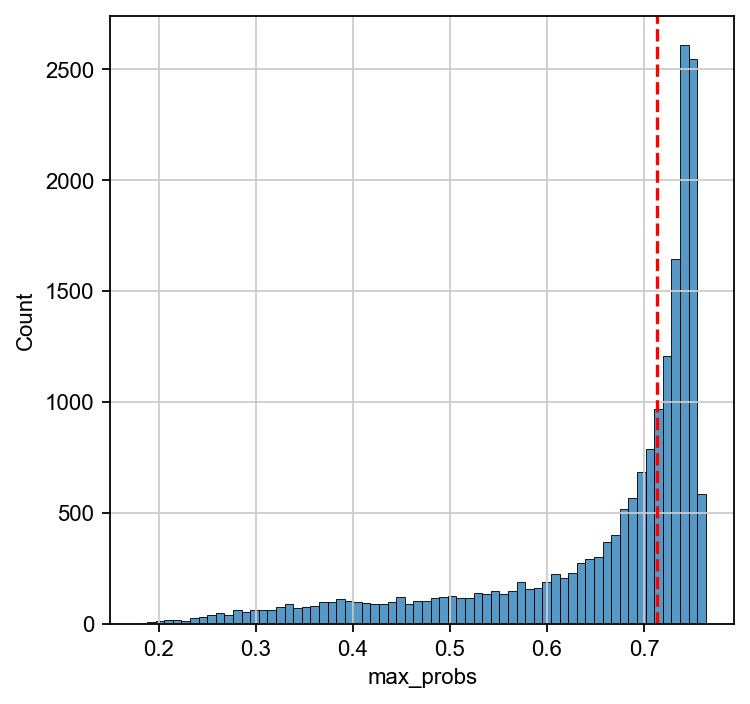

In [7]:
plt.figure(figsize=(5, 5)) 
sns.histplot(obs_sp['max_probs'])
plt.axvline(x=np.quantile(obs_sp['max_probs'], 0.50), color='red', linestyle='--')
plt.show()

In [8]:
#load embedding
hidden_list = STAMapper.load_hidden_states(folder_path/f'{best_model}'/'hidden_list.h5')
adt = sc.AnnData(hidden_list[-1]['cell'])
adt.obs['celltype'], adt.obs['predicted'], adt.obs['dataset'] = list(obs['celltype']), list(obs['predicted']), list(obs['dataset'])
sc.tl.pca(adt, svd_solver="arpack")
sc.pp.neighbors(adt, n_neighbors=10, n_pcs=40)
sc.tl.umap(adt)

adt_sc = adt[adt.obs['dataset'].isin([sc_name])]
adt_sp = adt[adt.obs['dataset'].isin([sp_name])]

dist_df= pipeline.ct_distace_df(key_class1, classes, adt_sc, adt_sp)

'threshold' is a user defined parameter, where cell-types with distance above the threshold will become potential unknown cells.

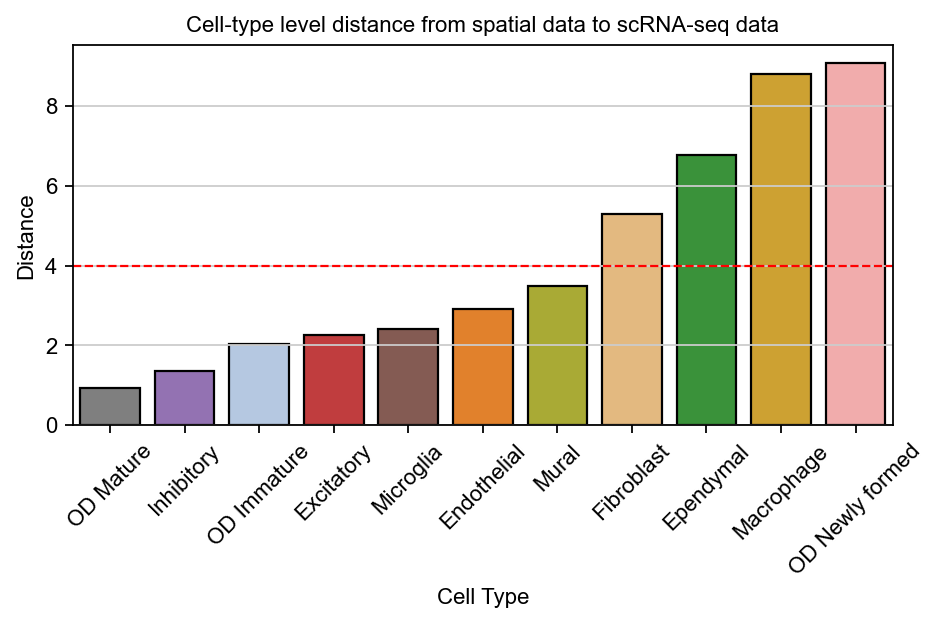

In [9]:
plt.figure(figsize=(6, 4)) 

palette = {'Astrocytes': '#1f77b4',
 'Inhibitory': '#9467bd',
 'Endothelial': '#ff7f0e',
 'Ependymal': '#2ca02c',
 'Excitatory': '#d62728',
 'Fibroblast': '#f3bb70',
 'Macrophage': '#e7ac18',
 'Microglia': '#8c564b',
 'Mural': '#bcbd22',
 'OD Immature': '#aec7e8',
 'OD Mature': '#7f7f7f',
 'OD Newly formed': '#fda1a0',
 'unknown':'#d2d1d1'}

threshold = 4#user defined parameter
sns.barplot(x='Cell Type', y='Distance', data=dist_df, palette=palette, linewidth=1, edgecolor='black')
plt.title('Cell-type level distance from spatial data to scRNA-seq data')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
adt = pipeline.add_unknown_prediction(obs_sc, obs_sp, dist_df, adt, threshold=threshold)#add 'pred_with_unknown' in adt.obs

Visualize the ground truth (upper panel) and the annotation of STAMapper (lower panel).

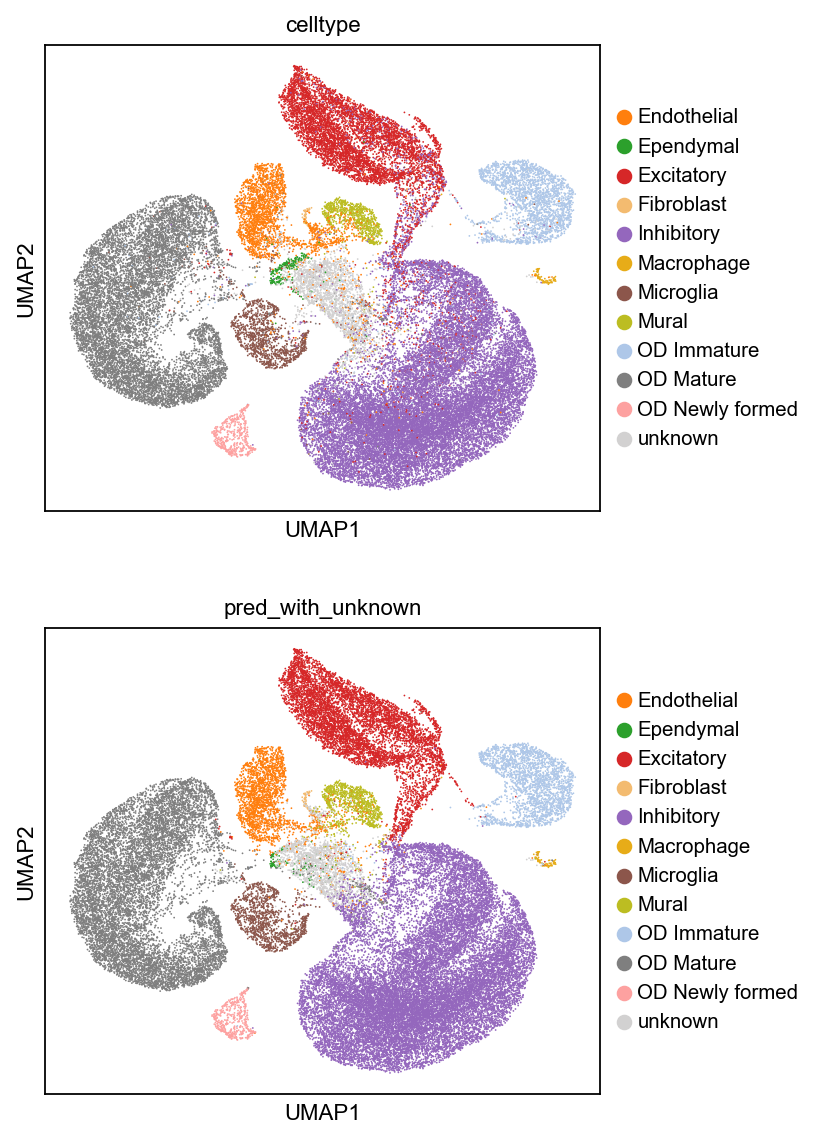

In [11]:
sc.pl.umap(adt, color=['celltype','pred_with_unknown'], palette=palette, ncols=1)

## Compare accuracy without/with unknown detection

In [12]:
adt_sp = adt[adt.obs['dataset'].isin([sp_name])]
acc_with_unknown_detection = np.mean(np.array(adt_sp.obs['celltype'])==np.array((adt_sp.obs['pred_with_unknown'])))
print(f"Accuracy without unknown detection: {accuracy:.3f}, Accuracy with unknown detection: {acc_with_unknown_detection:.3f}")

Accuracy without unknown detection: 0.759, Accuracy with unknown detection: 0.825
